In [1]:
import inspeqtor.experimental as sq
import numpyro
from numpyro import handlers
from numpyro import distributions as dist
import jax
import jax.numpy as jnp

from numpyro.infer import (
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_sample,
    Predictive,
)
import optax

In [16]:
sensitivity = 1.0


def model(l: jnp.ndarray):
    # Dimension -1 of `l` represents the number of rounds
    # Other dimensions are batch dimensions: we indicate this with a plate_stack
    with numpyro.plate_stack("plate", list(l.shape[:-1])):
        # Share theta across the number of rounds of the experiment
        # This represents repeatedly testing the same participant
        theta = numpyro.sample("theta", dist.Normal(7., 2.))  # type: ignore
        theta = jnp.expand_dims(theta, -1)
        # This define a *logistic regression* model for y
        logit_p = sensitivity * (theta - l)
        # The event shape represents responses from the same participant
        y = numpyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))  # type: ignore

    return y


def guide(l: jnp.ndarray):
    # The guide is initialised at the prior
    posterior_mean = numpyro.param("posterior_mean", jnp.array(7.0))
    posterior_sd = numpyro.param(
        "posterior_sd", jnp.array(2.0), constraint=dist.constraints.positive
    )
    numpyro.sample("theta", dist.Normal(posterior_mean, posterior_sd)) # type: ignore


In [17]:
l_data = jnp.array([5., 7., 9.])
y_data = jnp.array([1., 1., 0.])

conditioned_model = handlers.condition(model, {"y": y_data})

optimizer = optax.adamw(learning_rate=1e-3)

svi = SVI(
    model=conditioned_model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(optimizer),
    loss=TraceMeanField_ELBO(num_particles=1),
)

svi_results = svi.run(
    jax.random.key(0),
    10_000,
    l_data,
    progress_bar=True
)

100%|██████████| 10000/10000 [00:00<00:00, 10891.91it/s, init loss: 2.2569, avg. loss [9501-10000]: 1.2946]


In [18]:
svi_results.params

{'posterior_mean': Array(7.75896117, dtype=float64),
 'posterior_sd': Array(1.21964926, dtype=float64)}

In [19]:
def marginal_guide(design, observation_labels, target_labels):
    # This shape allows us to learn a different parameter for each candidate design l
    q_logit = numpyro.param("theta", jnp.zeros(design.shape[-2:]))
    numpyro.sample("y", dist.Bernoulli(logits=q_logit).to_event(1))  # type: ignore

In [21]:
candidate_designs = jnp.arange(1, 15, dtype=jnp.float_).reshape(-1, 1)

NUM_STEP = 10_000
optimizer = sq.optimize.get_default_optimizer(NUM_STEP)

eig, aux = sq.boed.estimate_eig(
    jax.random.key(0),
    model,
    marginal_guide,
    candidate_designs,  # design, or in this case, tensor of possible designs
    observation_labels=["y"],  # site label of observations, could be a list
    target_labels=["theta"],  # site label of 'targets' (latent variables), could also be list
    num_particles=100,  # number of samples to draw per step in the expectation
    num_optimization_steps=NUM_STEP,  # number of gradient steps
    optimizer=optimizer,  # optimizer with learning rate decay
    final_num_particles=10000,  # at the last step, we draw more samples
    # for a more accurate EIG estimate
    # loss_fn=sq.boed.vnmc_eig_loss
)

|████████████████████████████████████████| 10000/10000 [100%] in 12.7s (789.50/s


Text(0, 0.5, 'EIG($l$)')

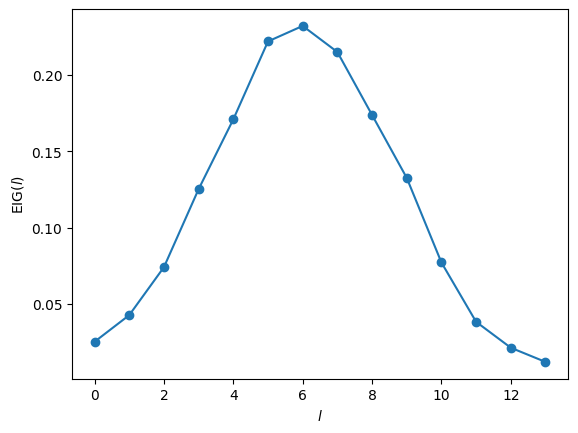

In [22]:
import matplotlib.pyplot as plt
plt.plot(eig, marker='o')
plt.xlabel("$l$")
plt.ylabel("EIG($l$)")

In [29]:
jnp.argmax(eig) + 1

Array(7, dtype=int64)